<a href="https://colab.research.google.com/github/mikonvergence/ControlNetInpaint/blob/main/ControlNet-with-Inpaint-Demo-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 💡 Note
If you're running this on colab, you might want to only run individual sections of this notebook corresponding to a specific type of model to avoid running out of memory.

In [1]:
! pip install diffusers==0.14.0 xformers transformers scipy ftfy accelerate controlnet_aux

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 32.0 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.15.0
    Uninstalling diffusers-0.15.0:
      Successfully uninstalled diffusers-0.15.0


In [2]:
! git clone https://github.com/mikonvergence/ControlNetInpaint
import sys
sys.path.append('./ControlNetInpaint/')

fatal: destination path 'ControlNetInpaint' already exists and is not an empty directory.


# Inpainting with ControlNet
This notebook contains examples of using a new `StableDiffusionControlNetInpaintPipeline`.

The main two parameters you can play with are the strength of text guidance and image guidance:
* Text guidance (`guidance_scale`) is set to `7.5` by default, and usually this value works quite well.
* Image guidance (`controlnet_conditioning_scale`) is set to `0.4` by default. This value is a good starting point, but can be lowered if there is a big misalignment between the text prompt and the control image (meaning that it is very hard to "imagine" an output image that both satisfies the text prompt and aligns with the control image).

The naming of these parameters is based on other pipelines `StableDiffusionInpaintPipeline` and `StableDiffusionControlNetPipeline` and the same convention has been preserved for consistency.

In [3]:
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from src.pipeline_stable_diffusion_controlnet_inpaint import *
from diffusers.utils import load_image

import cv2
from PIL import Image
import numpy as np
import torch
from matplotlib import pyplot as plt

### Baseline: Stable Diffusion 1.5 Inpainting
The StableDiffusion1.5 Inpainting model is used as the core for ControlNet inpainting. For reference, you can also try to run the same results on this core model alone:

In [4]:
pipe_sd = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
# speed up diffusion process with faster scheduler and memory optimization
pipe_sd.scheduler = UniPCMultistepScheduler.from_config(pipe_sd.scheduler.config)
# remove following line if xformers is not installed
pipe_sd.enable_xformers_memory_efficient_attention()

pipe_sd.to('cuda')

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.14.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Task
Let's start by turning this dog into a red panda using various types of guidance!

All we need is an `image`, a `mask`, and a `text_prompt` of **"a red panda sitting on a bench"**

Text(0.5, 1.0, 'Masked')

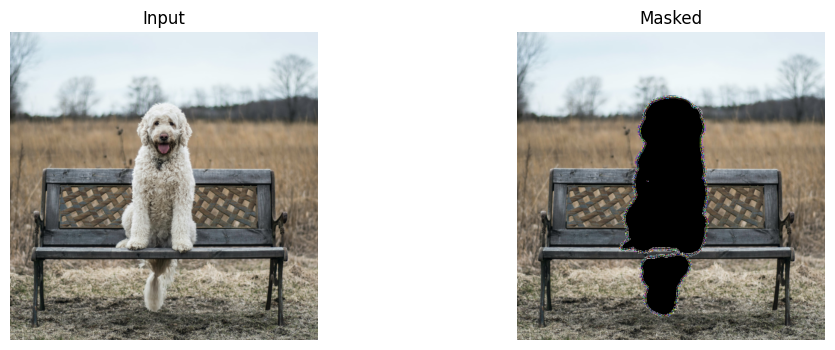

In [6]:
# download an image
image = load_image(
     "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
)
image = np.array(image)
mask_image = load_image(
     "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
)
mask_image = np.array(mask_image)

text_prompt="a red panda sitting on a bench"

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')

## Canny Edge

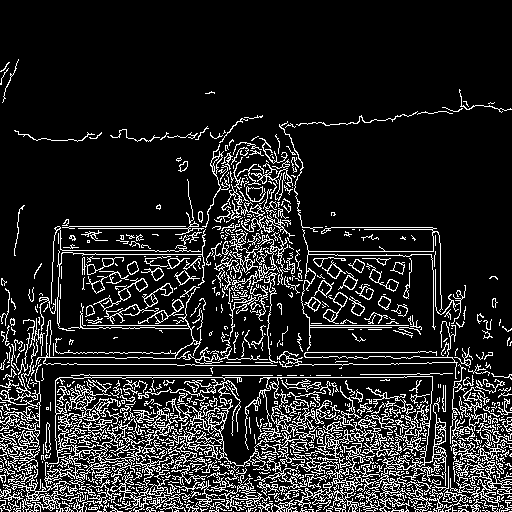

In [7]:
# get canny image
canny_image = cv2.Canny(image, 100, 200)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)

image=Image.fromarray(image)
mask_image=Image.fromarray(mask_image)
canny_image = Image.fromarray(canny_image)

canny_image

In [8]:
# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### Scaling image control...
In this example, `canny_image` input is actually quite hard to satisfy with the our text prompt due to a lot of local noise. In this special case, we adjust `controlnet_conditioning_scale` to `0.5` to make this guidance more subtle.

In all other examples, the default value of `controlnet_conditioning_scale` = `1.0` works rather well!

  0%|          | 0/20 [00:00<?, ?it/s]

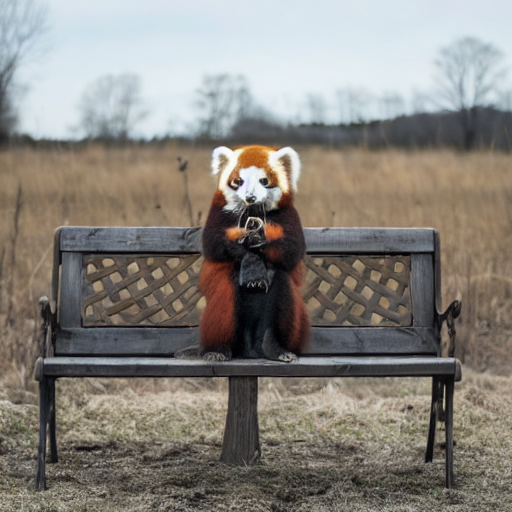

In [9]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=canny_image,
    controlnet_conditioning_scale = 0.5,
    mask_image=mask_image
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(canny_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

### Comparison: vanilla inpainting from StableDiffusion1.5

In [ ]:
# generate image
generator = torch.manual_seed(0)
new_image = pipe_sd(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    mask_image=mask_image
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,3,3)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

## Challenging Examples 🐕➡️🍔
Let's see how tuning the `controlnet_conditioning_scale` works out for a more challenging example of turning the dog into a cheeseburger!

In this case, we **demand a large semantic leap** and that requires a more subtle guide from the control image!

In [ ]:
difficult_text_prompt="a big cheeseburger sitting on a bench"

In [ ]:
# First - StableDiffusion1.5 baseline (no ControlNet)

# generate image
generator = torch.manual_seed(0)
new_image = pipe_sd(
    difficult_text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    mask_image=mask_image
).images[0]

sd_output=new_image
sd_output

In [ ]:
# and now, let's loop through different values of controlnet_conditioning_scale

pipe.to('cuda')

outputs=[]

# here, we will test 8 values between 0.0 and 1.0
val_N=8
factor=(1/(val_N-1))

for ccs in range(val_N):

    # generate image
    generator = torch.manual_seed(0)
    new_image = pipe(
        difficult_text_prompt,
        num_inference_steps=20,
        generator=generator,
        image=image,
        control_image=canny_image,
        controlnet_conditioning_scale = ccs*factor,
        mask_image=mask_image
    ).images[0]
    
    outputs.append(new_image)

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(3,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(3,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(3,4,3)
plt.imshow(canny_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(3,4,4)
plt.imshow(sd_output)
plt.title('SD1.5 Output\n(No ControlNet)')
plt.axis('off')

for idx,img in enumerate(outputs):
    plt.subplot(3,4,5+idx)
    plt.imshow(img)
    plt.title('ControlNet Scale:\n{:.2f}'.format(idx*factor))
    plt.axis('off')

plt.tight_layout()

plt.savefig('output/canny_cheeseburger_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')

idx=2
plt.subplot(1,3,3)
plt.imshow(outputs[idx])
plt.title('ControlNet Scale:\n{:.2f}'.format(idx*factor))
plt.axis('off')

plt.tight_layout()

plt.savefig('output/canny_cheeseburger.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

## HED

In [ ]:
from controlnet_aux import HEDdetector

hed = HEDdetector.from_pretrained('lllyasviel/ControlNet')

hed_image = hed(image)

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-hed", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=hed_image,
    mask_image=mask_image
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(hed_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

### Scribble

In [ ]:
from controlnet_aux import HEDdetector

hed = HEDdetector.from_pretrained('lllyasviel/ControlNet')

scribble_image = hed(image,scribble=True)

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-scribble", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=scribble_image,
    mask_image=mask_image
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(scribble_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

### Depth

In [ ]:
from transformers import pipeline

depth_estimator = pipeline('depth-estimation')

depth_image = depth_estimator(image)['depth']
depth_image = np.array(depth_image)
depth_image = depth_image[:, :, None]
depth_image = np.concatenate(3*[depth_image], axis=2)
depth_image = Image.fromarray(depth_image)

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-depth", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=depth_image,
    mask_image=mask_image
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(depth_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

### Normal Map

In [ ]:
import cv2

depth_estimator = pipeline("depth-estimation", model ="Intel/dpt-hybrid-midas" )

normal_image = depth_estimator(image)['predicted_depth'][0]

normal_image = normal_image.numpy()

image_depth = normal_image.copy()
image_depth -= np.min(image_depth)
image_depth /= np.max(image_depth)

bg_threhold = 0.4

x = cv2.Sobel(normal_image, cv2.CV_32F, 1, 0, ksize=3)
x[image_depth < bg_threhold] = 0

y = cv2.Sobel(normal_image, cv2.CV_32F, 0, 1, ksize=3)
y[image_depth < bg_threhold] = 0

z = np.ones_like(x) * np.pi * 2.0

normal_image = np.stack([x, y, z], axis=2)
normal_image /= np.sum(normal_image ** 2.0, axis=2, keepdims=True) ** 0.5
normal_image = (normal_image * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
normal_image = Image.fromarray(normal_image).resize((512,512))

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-normal", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=normal_image,
    mask_image=mask_image
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(normal_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

### More control input types
For these control input types, we will use a different image as in those cases, an image of the dog on the bench is not appropriate!

Let's start with a room photo...

### M-LSD

In [ ]:
from controlnet_aux import MLSDdetector

mlsd = MLSDdetector.from_pretrained('lllyasviel/ControlNet')

room_image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-mlsd/resolve/main/images/room.png")

mlsd_image = mlsd(room_image).resize(room_image.size)

In [ ]:
room_mask=np.zeros_like(np.array(room_image))
room_mask[120:420,220:,:]=255
room_mask=Image.fromarray(room_mask)


room_mask=room_mask.resize((512,512))
mlsd_image=mlsd_image.resize((512,512))
room_image=room_image.resize((512,512))

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-mlsd", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "an image of a room with a city skyline view",
    num_inference_steps=20,
    generator=generator,
    image=room_image,
    control_image=mlsd_image,
    mask_image=room_mask
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(room_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(room_image))*(255-np.array(room_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(mlsd_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

### OpenPose

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
from controlnet_aux import OpenposeDetector

openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

pose_real_image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-openpose/resolve/main/images/pose.png")

pose_image = openpose(pose_real_image)
pose_real_image=pose_real_image.resize(pose_image.size)

pose_mask=np.zeros_like(np.array(pose_image))
pose_mask[250:700,:,:]=255
pose_mask=Image.fromarray(pose_mask)

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "a man in a knight armor",
    num_inference_steps=20,
    generator=generator,
    image=pose_real_image,
    control_image=pose_image,
    mask_image=pose_mask
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(pose_real_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(pose_real_image))*(255-np.array(pose_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(pose_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

### Segmentation Mask

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-seg", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
house_real_image=load_image("https://huggingface.co/lllyasviel/sd-controlnet-seg/resolve/main/images/house.png")
seg_image=load_image("https://huggingface.co/lllyasviel/sd-controlnet-seg/resolve/main/images/house_seg.png")

house_mask=np.zeros((*seg_image.size,3),dtype='uint8')
house_mask[50:400,-350:,:]=255
house_mask=Image.fromarray(house_mask)

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "a pink eerie scary house",
    num_inference_steps=20,
    generator=generator,
    image=house_real_image,
    control_image=seg_image,
    mask_image=house_mask
).images[0]

new_image

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(house_real_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(house_real_image))*(255-np.array(house_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(seg_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')